# CS4035 - Cyber Data Analytics
## Lab 3 

## Group Number: 69

## Student 1 
### Name : Konrad Ponichtera
### ID : 5580749

## Student 2
### Name : Ion Babalau
### ID : 5626110

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbformat

from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer


In [2]:
nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 234


## README

Expected location of dataset: _data_ directory, in same directory as notebook. 
All the necessary packages are specifeid in _requirements.txt_, and can be installed with the command: `pip install -r requirements.txt`

## 1. Familiarization and discretization task – 1 A4 (5 Points)

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [3]:
df = pd.read_csv("data/dataset_10/capture20110818.binetflow")

infected_hosts = [
'147.32.84.165',
'147.32.84.191',
'147.32.84.192',
'147.32.84.193',
'147.32.84.204',
'147.32.84.205',
'147.32.84.206',
'147.32.84.207',
'147.32.84.208',
'147.32.84.209'
]

print('Dataset size:', len(df))

df.head()

Dataset size: 1309791


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


### Analyzing labels

In [4]:
def filter_benign(df):
    return df[~df['SrcAddr'].isin(infected_hosts)]

def filter_infected(df):
    return df[df['SrcAddr'].isin(infected_hosts)]

In [5]:
df_benign = filter_benign(df)
df_infected = filter_infected(df)

print('Data entries count:', len(df))
print('Data entries count from benign hosts:', len(df_benign))
print('Data entries count from infected hosts:', len(df_infected))

Data entries count: 1309791
Data entries count from benign hosts: 1203426
Data entries count from infected hosts: 106365


In [6]:
df_benign.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


In [7]:
df_infected.head()
#df_infected.Label.unique()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
90622,2011/08/18 10:37:58.448307,0.000342,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,flow=From-Botnet-V51-1-UDP-DNS
90808,2011/08/18 10:38:00.695278,0.010278,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,flow=From-Botnet-V51-1-UDP-DNS
90809,2011/08/18 10:38:00.706560,0.043726,tcp,147.32.84.165,1027,->,74.125.232.206,80,SRPA_SPA,0.0,0.0,7,882,629,flow=From-Botnet-V51-1-TCP-HTTP-Google-Net-Est...
90965,2011/08/18 10:38:03.255934,0.010256,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,479,76,flow=From-Botnet-V51-1-UDP-DNS
90968,2011/08/18 10:38:03.267222,581.516663,udp,147.32.84.165,123,->,65.55.56.40,123,INT,0.0,NaN,4,360,360,flow=From-Botnet-V51-1-UDP-Attempt


### Visualizing features

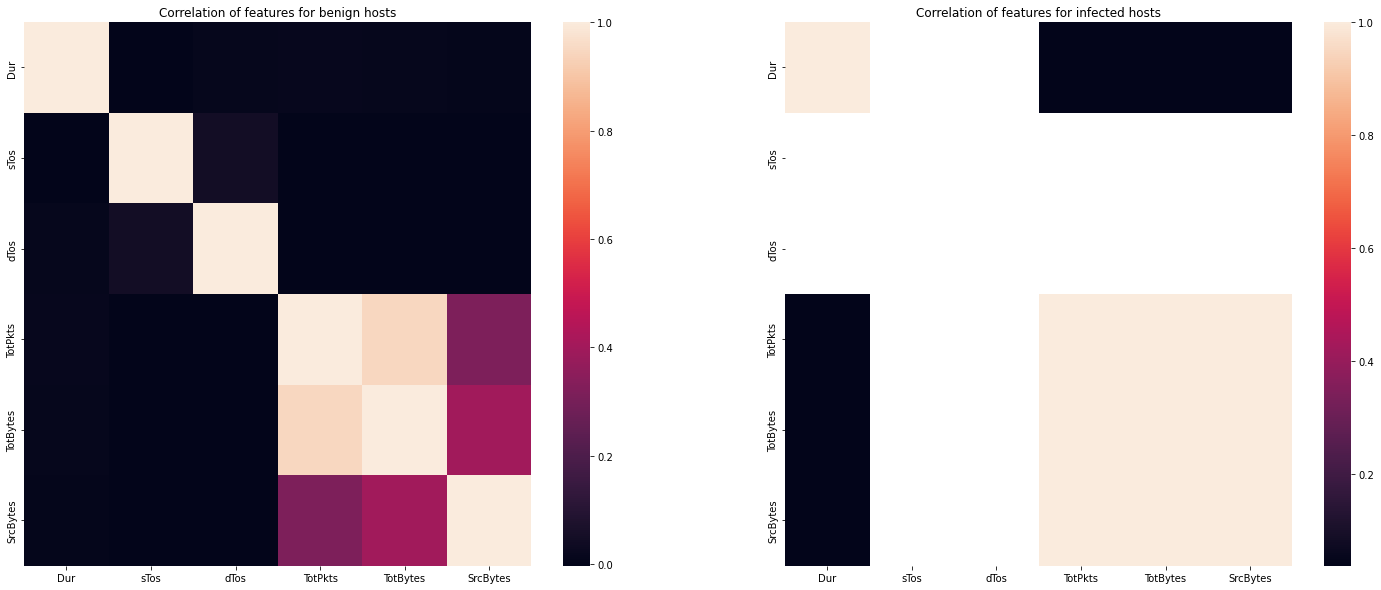

In [8]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

ax1.set_title('Correlation of features for benign hosts')
sns.heatmap(df_benign.corr(), ax=ax1)

ax2.set_title('Correlation of features for infected hosts')
sns.heatmap(df_infected.corr(), ax=ax2)

plt.show()

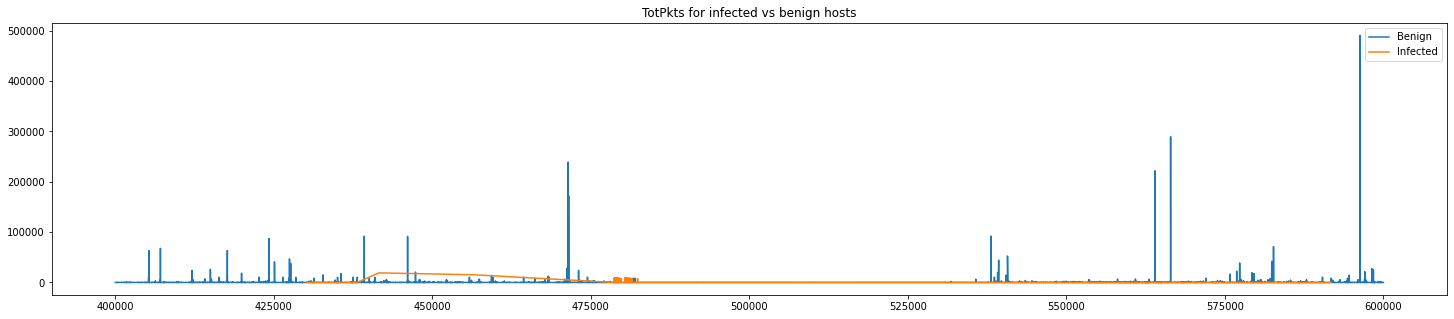

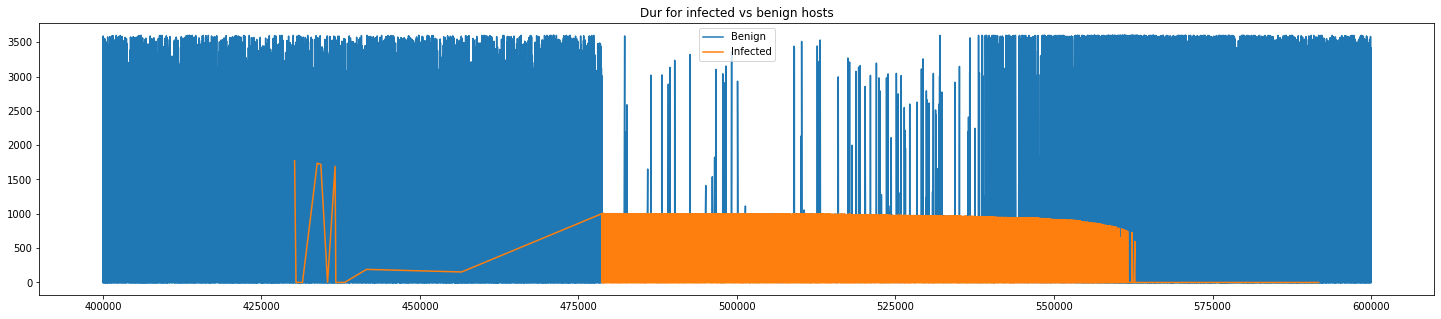

In [9]:
features = ['TotPkts', 'Dur']

df_fragment = df[400000:600000]

df_fragment_infected = filter_infected(df_fragment)
df_fragment_benign = filter_benign(df_fragment)

_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df_fragment_benign[features[0]])
ax.plot(df_fragment_infected[features[0]])
ax.set_title(features[0] + ' for infected vs benign hosts')
ax.legend(labels=['Benign', 'Infected'])
plt.show()

_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df_fragment_benign[features[1]])
ax.plot(df_fragment_infected[features[1]])
ax.set_title(features[1] + ' for infected vs benign hosts')
ax.legend(labels=['Benign', 'Infected'])
plt.show()


### 1b. Discretize selected features

In [10]:
def discretize(discretizer, feature_array):
    """
    Discretizes the passed data.

    Arguments:
        discretizer: Discretizer, fitted with the learning data
        feature_array: Numpy array with data to discretize, using the passed discretizer
    Returns:
        Discretized data, passed as feature_array argument
    """
    bins = discretizer.transform(feature_array)[:, 0]
    vectorizer = np.vectorize(lambda x: int(discretizer.bin_edges_[0][int(x)]))

    return vectorizer(bins)

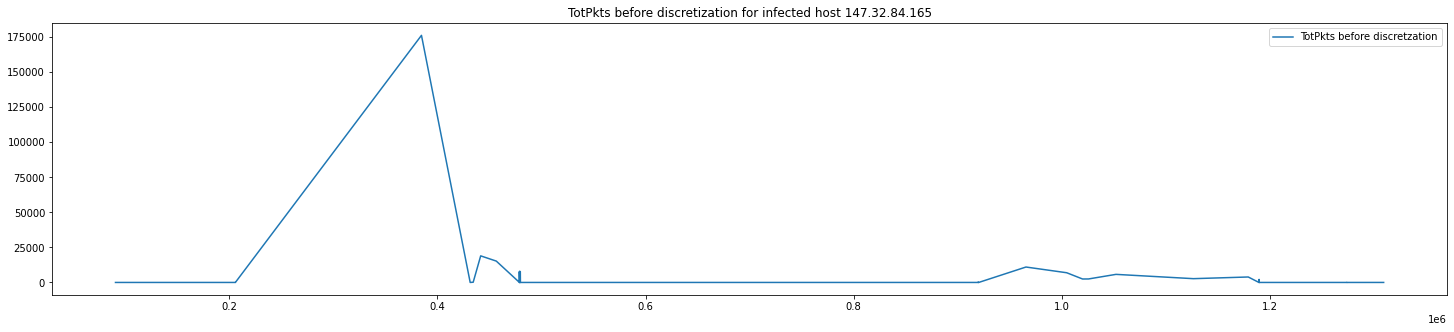

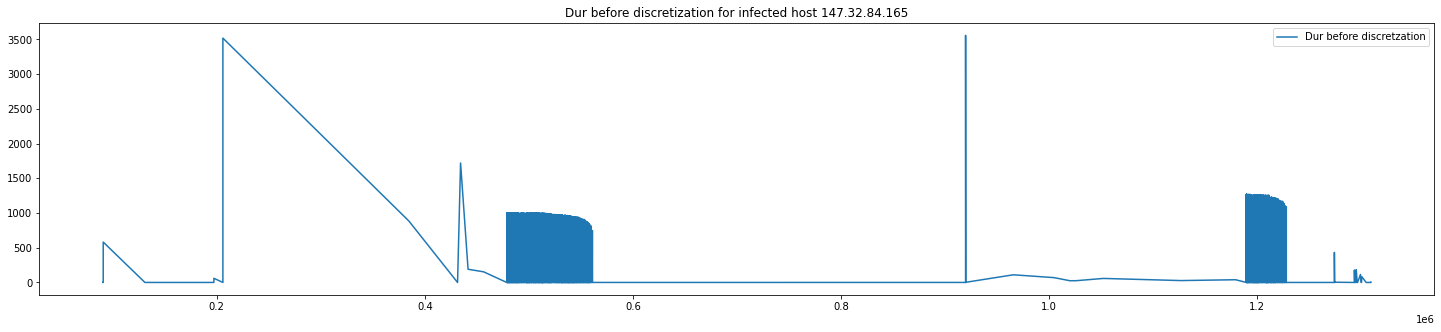

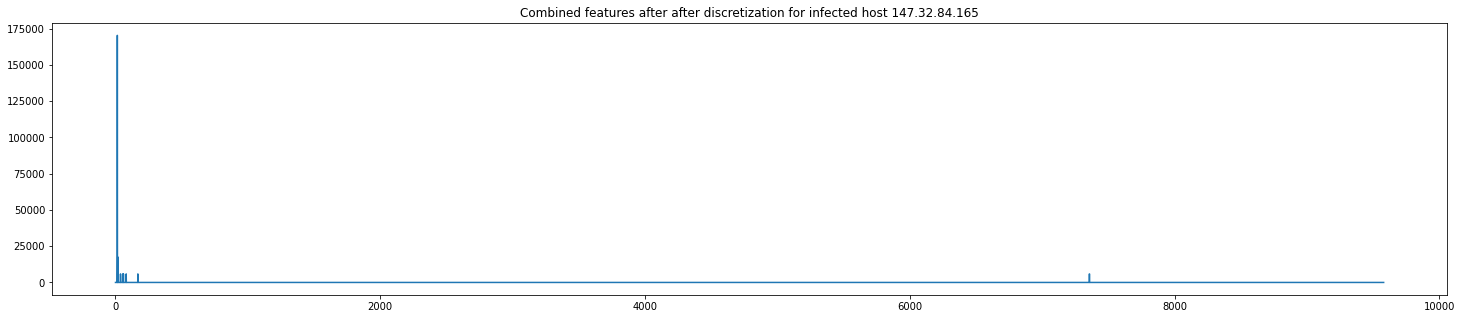

In [11]:
# Ignoring the FutureWarning which is internally thrown by NearestNeighbors
#warnings.simplefilter(action='ignore', category=UserWarning)
# choose a host
from sklearn.decomposition import PCA
host = '147.32.84.165'
df_host = df[df['SrcAddr'] == host]

for i in range(len(features)):
    _, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax.plot(df_host[features[i]])
    ax.legend(labels=[f'{features[i]} before discretzation'], loc='upper right')
    ax.set_title(f'{features[i]} before discretization for infected host 147.32.84.165') 
    plt.show()

features_combined = df_host[features].copy()
pca = PCA(n_components=1, random_state=0)
features_reduced = pca.fit_transform(features_combined)
discretizer = KBinsDiscretizer(n_bins=30, strategy='uniform', encode='ordinal')
discretizer.fit(features_reduced)
feature_discretized = discretize(discretizer, features_reduced)

_, ax = plt.subplots(1, 1, figsize=(25, 5))
#ax.set_ylim([None, 20])
ax.plot(feature_discretized)
ax.set_title(f'Combined features after after discretization for infected host 147.32.84.165') 
plt.show()

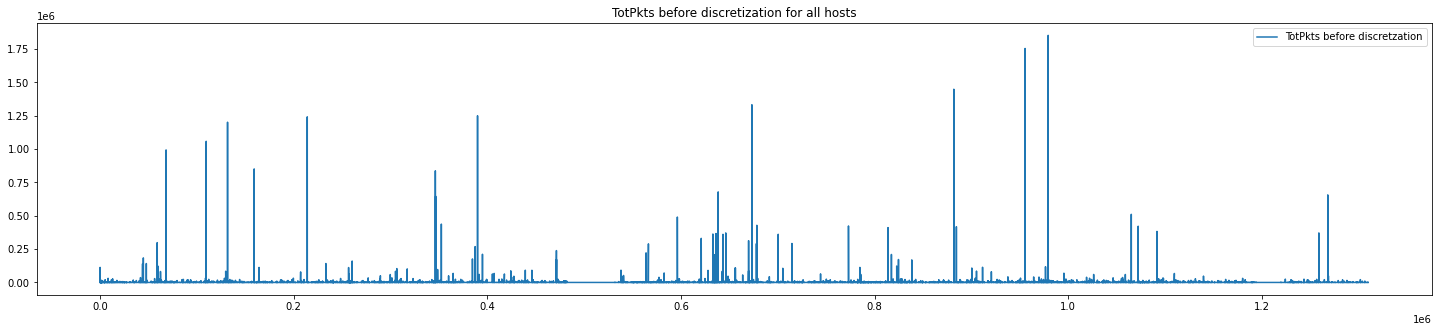

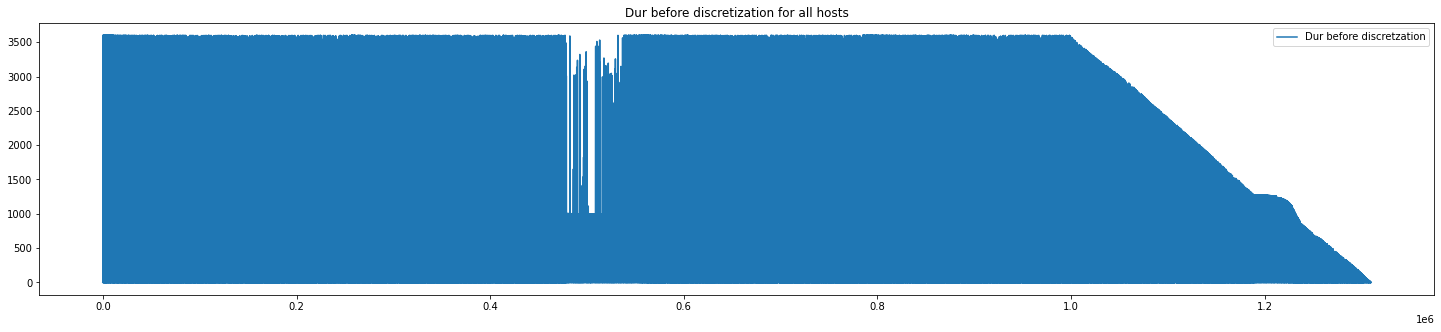

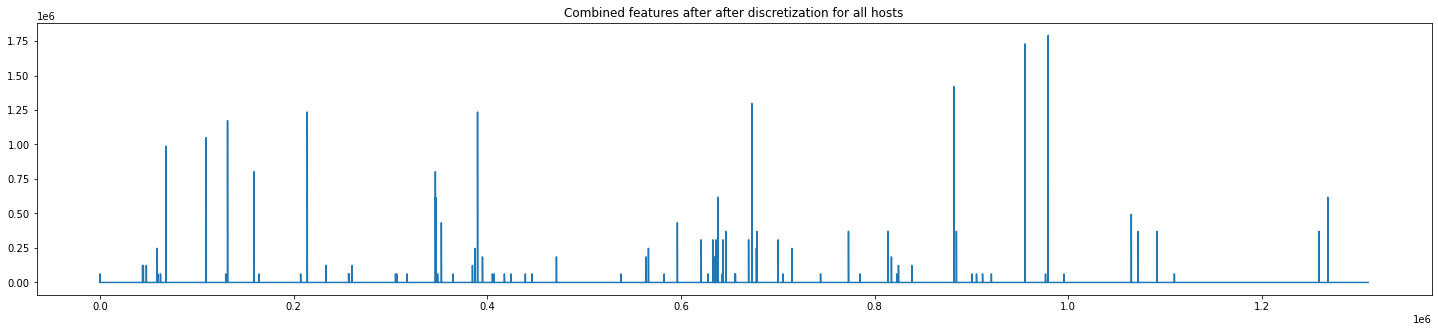

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,TotPkts_Dur
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt,-48
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt,-48
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established,-48
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt,-48
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt,-48


In [34]:
# applying to all hosts
for i in range(len(features)):
    _, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax.plot(df[features[i]])
    ax.legend(labels=[f'{features[i]} before discretzation'], loc='upper right')
    ax.set_title(f'{features[i]} before discretization for all hosts') 
    plt.show()


features_combined = df[features].copy()
pca = PCA(n_components=1, random_state=0)
features_reduced = pca.fit_transform(features_combined)
discretizer = KBinsDiscretizer(n_bins=30, strategy='uniform', encode='ordinal')
discretizer.fit(features_reduced)
feature_discretized = discretize(discretizer, features_reduced)

comb_col_name = features[0] + '_' + features[1]
df[comb_col_name] = feature_discretized
_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(feature_discretized)
ax.set_title(f'Combined features after after discretization for all hosts') 
plt.show()
df.head()

### 1c. Answers and explanation

Firstly, when analyzing the correlation plots for benign and infected traffic, we notice that for the infected hosts, the correlation between the number of packets and the number of bytes sent is higher. This might mean that each packet sent by an infected host had a similar size, so sending more packets also resulted in more bytes.


## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


### 2b. Analysis and answers to the questions

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

In [35]:
df_minlsh = df.copy()
counts = df_minlsh.groupby(['SrcAddr', 'DstAddr']).count()
# create a set of ip pairs which appear more than 3 times
ip_prof_set = set()
for row in counts.iterrows():
    if row[1][0] >= 3:
        ip_prof_set.add(row[0])
print(len(ip_prof_set))

# create a set of all possible 3grams
gram_set = set()
sorted_stuff = df_minlsh.sort_values(['SrcAddr', 'DstAddr']).reset_index()[comb_col_name]
for i in range(len(sorted_stuff) - 2):
    gram_set.add((sorted_stuff[i], sorted_stuff[i + 1], sorted_stuff[i + 2]))
print(len(gram_set))

# create new field for ip pairs
temp = []
df_minlsh.apply(lambda x: temp.append((x['SrcAddr'], x['DstAddr'])), axis=1)
df_minlsh['SrcDstAddr'] = temp
df_minlsh.head()

44851
75


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,TotPkts_Dur,SrcDstAddr
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt,-48,"(93.45.239.29, 147.32.84.118)"
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt,-48,"(62.240.166.118, 147.32.84.229)"
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established,-48,"(147.32.86.148, 66.235.132.232)"
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt,-48,"(147.32.3.51, 147.32.84.46)"
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt,-48,"(88.212.37.169, 147.32.84.118)"


In [36]:
df_minlsh = df_minlsh.sort_values(['SrcAddr', 'DstAddr'])
df_minlsh = df_minlsh.reset_index()
src_dst_ip = df_minlsh['SrcDstAddr']
combined_feature = df_minlsh[comb_col_name]

ip_profiles_3grams = dict()
ip_prof_list = list(ip_prof_set)
gram_list = list(gram_set)
# intialize dict
for i in range(len(ip_prof_list)):
    ip_profiles_3grams[ip_prof_list[i]] = np.zeros(len(gram_list))

# create 3grams for each ip pair
for i in range(len(src_dst_ip) - 2):
    if src_dst_ip[i] == src_dst_ip[i + 1] == src_dst_ip[i + 2]:
        ngram = (combined_feature[i], combined_feature[i + 1], combined_feature[i + 2])
        gram_index = gram_list.index(ngram)
        ip_profiles_3grams[src_dst_ip[i]][gram_index] = 1
df_minlsh.head()

,index,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,TotPkts_Dur,SrcDstAddr
0,2805,2011/08/18 10:19:37.939580,3599.097168,udp,0.0.0.0,68,->,255.255.255.255,67,INT,0.0,NaN,377,125194,125194,flow=Background-UDP-Attempt,-48,"(0.0.0.0, 255.255.255.255)"
1,258516,2011/08/18 11:19:41.526759,3535.465088,udp,0.0.0.0,68,->,255.255.255.255,67,REQ,0.0,NaN,366,121542,121542,flow=Background-UDP-Attempt,-48,"(0.0.0.0, 255.255.255.255)"
2,548560,2011/08/18 12:19:42.992686,3599.996094,udp,0.0.0.0,68,->,255.255.255.255,67,REQ,0.0,NaN,301,99950,99950,flow=Background-UDP-Attempt,-48,"(0.0.0.0, 255.255.255.255)"
3,788105,2011/08/18 13:19:55.987624,3590.950684,udp,0.0.0.0,68,->,255.255.255.255,67,REQ,0.0,NaN,363,120428,120428,flow=Background-UDP-Attempt,-48,"(0.0.0.0, 255.255.255.255)"
4,1075801,2011/08/18 14:19:57.990221,2698.995850,udp,0.0.0.0,68,->,255.255.255.255,67,REQ,0.0,NaN,232,76880,76880,flow=Background-UDP-Attempt,-48,"(0.0.0.0, 255.255.255.255)"


In [82]:
import math

def min_hash(ip_profiles_3grams, bin_size):
    hash_func = lambda x: (np.sum(x) * (np.sum(x) + 3)) % bin_size
    sim_score = dict()
    sim_list = []
    for index, bin_vector in enumerate(ip_profiles_3grams.values()):
        h = hash(tuple(bin_vector)) % bin_size
        if h in sim_score:
            sim_score[h].append(index)
        else:
            sim_score[h] = [index]
        sim_list.append(h)
    return sim_score, sim_list

sim_array, sim_list = min_hash(ip_profiles_3grams, 5) #len(ip_profiles_3grams.keys()))
print(sim_array.keys())

dict_keys([3, 4, 1, 0, 2])


In [83]:
from sklearn.neighbors import NearestNeighbors
X = np.array(list(ip_profiles_3grams.values()))
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
print(indices)

X = np.array(sim_list).reshape(-1, 1)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
_, indices_lsh = nbrs.kneighbors(X)
print(indices_lsh)


[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [88]:
test_dict = dict()
for index, val in enumerate(indices):
    val = val[0]
    if val in test_dict:
        test_dict[val].append(index)
    else:
        test_dict[val] = [index]

def sim_error(y_true, y_pred):
    sum = 0
    for ind in y_pred:
        if ind in y_true:
            sum += 1
    sum /= len(y_pred)
    return sum

from sklearn.metrics import mean_squared_error, accuracy_score, jaccard_score

y_true = list(map(lambda x: x[0], indices))
y_pred = list(map(lambda x: x[0], indices_lsh))

print(jaccard_score(y_true, y_pred, average='weighted'))

0.9987054727278736


In [85]:
print(np.unique(y_true))
print(np.unique(y_pred))


[    0   284  2376  3023  3894  3955  4176  5409  6085  6254  9400 10963
 12567 12822 16014 18513 18717 19288 19808 20599 21382 22319 22536 23199
 23826 24837 25178 27700 28707 30613 36908 37966 40017 40865 44844]
[    0  3955  4176 10963 22536]


### 3b. Analysis and answers to the questions

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

In [ ]:
flex_train = training_data.copy()
flex_train = encode_data(flex_train, label_only=True) # Converts labels to 0 for normal and 1 for botnet; background removed

flex_train = flex_train[['combined_discretized', 'Label']] # combined_discretized is the column computed in task 1 using 2 features
flex_train.reset_index(drop=True, inplace=True)

flex_train = flex_train.rename(columns={"combined_discretized": "symb", "Label":"type"})

flexfringe = FlexFringe(
    flexfringe_path="binaries/flexfringe-x64-windows",
    heuristic_name="alergia",
    data_name="alergia_data",
    slidingwindow=10,
    swsize=1,
)

# Learn a state machine
flexfringe.fit(flex_train,
               sinkson=1,
               sinkcount=100)

# Use state machine to predict likelihoods
df = flexfringe.predict(flex_train)

print(df.head())

### 4b. Analysis and answers to the questions.

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.